In [1]:
cd '/home/dpirvu/axion/'

/home/dpirvu/axion


In [2]:
%matplotlib inline

import os,sys
sys.path.remove('/home/dpirvu/DarkPhotonxunWISE/hmvec-master')
sys.path.append('/home/dpirvu/axion/hmvec-master/')
print([ii for ii in sys.path])

import hmvec as hm

from compute_power_spectra import *
from params import *
from plotting import *
from scipy import interpolate

np_load_old = np.load
np.load     = lambda *a,**k: np_load_old(*a, allow_pickle=True, **k)


['/home/dpirvu/axion', '/cm/shared/apps/python/python37/lib/python37.zip', '/cm/shared/apps/python/python37/lib/python3.7', '/cm/shared/apps/python/python37/lib/python3.7/lib-dynload', '', '/home/dpirvu/.local/lib/python3.7/site-packages', '/cm/shared/apps/python/python37/lib/python3.7/site-packages', '/cm/shared/apps/python/python37/lib/python3.7/site-packages/IPython/extensions', '/home/dpirvu/.ipython', '/home/dpirvu/axion/hmvec-master/']


In [5]:
get_cell_galtau      = False
get_cell_gg_no_sats  = False
get_cell_galtau_cen  = False
get_cell_galtau_for_SAM = True

In [4]:
ellMax = 9600
ells = np.arange(ellMax)

nZs = 50
nMs = 100
zMin = 0.005
zreio = 1.9
zMax = zreio

ms  = np.geomspace(1e11,1e17, nMs) # masses
zs  = np.linspace(0.005,zreio,nZs) # redshifts
ks  = np.geomspace(1e-4,1e3, 5001) # wavenumbers

rscale = False

In [18]:
if get_cell_galtau_for_SAM:
    # Select electron profile
    for name in ['battagliaAGN']:
        for color in ['blue', 'green']:
            unwise_color = color
            for choose in [21]:
                choose_dict = choose
                print('Doing ', name, unwise_color, choose_dict)

                if unwise_color=='blue': pathdndz = "/home/dpirvu/DarkPhotonxunWISE/dataHOD/normalised_dndz_cosmos_0.txt"
                elif unwise_color=='green': pathdndz = "/home/dpirvu/DarkPhotonxunWISE/dataHOD/normalised_dndz_cosmos_1.txt"

                # Halo Model
                hcos = hm.HaloModel(zs, ks, ms=ms, mass_function='tinker', mdef='vir', concmode='BHATTACHARYA', unwise_color=unwise_color, choose_dict=choose_dict)
                chis     = hcos.comoving_radial_distance(zs)
                rvirs    = hcos.rvir(ms[None,:],zs[:,None])
                cs       = hcos.concentration()
                Hz       = hcos.h_of_z(zs)
                nzm      = hcos.get_nzm()
                biases   = hcos.get_bh()
                deltav   = hcos.deltav(zs)
                rhocritz = hcos.rho_critical_z(zs)
                m200c, r200c = get_200critz(zs, ms, cs, rhocritz, deltav)
                dvols = get_volume_conv(chis, Hz)

                hcos.add_hod(name=unwise_color)
                Ncs  = hcos.hods[unwise_color]['Nc']
                Nss  = hcos.hods[unwise_color]['Ns']
                ngal = hcos.hods[unwise_color]['ngal']
                hod, uc, us = hcos._get_hod_common(unwise_color)

                dndz, zs, N_gtot, W_g, zsHOD, dndzHOD = get_dndz(zs, pathdndz, dvols)

                uk_g   = (      Ncs[None,:,None] + us     * Nss[None,:,None]    ) / ngal[:,None,None]
                uk_gsq = (2.*us*Nss[None,:,None] + us**2. * Nss[None,:,None]**2.) / ngal[:,None,None]**2.
                PzkLin = hcos._get_matter_power(zs, ks, nonlinear=False)

                Pzell, uell_g, uell_gsq = get_fourier_to_multipole_functs(zs, ms, ks, chis, W_g, ellMax, uk_g, uk_gsq, PzkLin)
                print('Done turning into multipoles.')

                ellFinal = 6001
                data_save = np.zeros((len(dictKey), ellFinal))
                for mind, MA in enumerate(dictKey):
                    zMin, zMax, rMin, rMax = chooseModel(MA, modelParams)
                    zMax = min(zreio, zMax)

                    path_params0 = np.asarray([MA, nZs, zMin, zMax, ellMax, rscale])
                    rcross, prob, utheta, avtau, dtaudz, uell0 = np.load(data_path(*path_params0))

                    screeningProbell = (prob * utheta)[None,...] * uell0
                    zell_tau = (screeningProbell[:ellMax]).transpose(1,2,0) * np.sqrt((4.*np.pi)/(2*ells+1))[None,None,:]

                    # Assemble power spectra
                    int_uell_g_1h = np.trapz(nzm[...,None] * uell_gsq         , ms, axis=1)
                    int_zell_taug = np.trapz(nzm[...,None] * zell_tau * uell_g, ms, axis=1)

                    int_uell_g_2h = np.trapz(nzm[...,None] * biases[...,None] * uell_g  , ms, axis=1)
                    int_zell_tau  = np.trapz(nzm[...,None] * biases[...,None] * zell_tau, ms, axis=1)

                    Cell_taug_1h  = np.trapz(dvols[:,None] * int_zell_taug                       , zs, axis=0)
                    Cell_taug_2h  = np.trapz(dvols[:,None] * int_zell_tau * int_uell_g_2h * Pzell, zs, axis=0)
                    Cell_taug_tot = Cell_taug_1h + Cell_taug_2h

                    baseline = ghztoev(353)
                    units = xov(baseline) * baseline
                    data_save[mind] = Cell_taug_tot[:ellFinal] * TCMB * units
                    print('Done', mind, 'out of', len(dictKey))

                np.save('/home/dpirvu/axion/data_axion_Tg_'+name+'_'+unwise_color+'_HOD'+str(choose_dict)+'.npy', data_save)
                print('Done ', name, unwise_color, choose_dict)


Doing  battagliaAGN blue 21
unwise_color blue choose_dict 21 hod_params {'hod_alphasat': 1.06, 'hod_siglogM': 0.02, 'hod_lambda': 1.8, 'hod_M1pr_satdivh': 4074000000000.0, 'hod_Mmin_cendivh': 489780000000.0}
Done turning into multipoles.
Done 0 out of 65
Done 1 out of 65
Done 2 out of 65
Done 3 out of 65
Done 4 out of 65
Done 5 out of 65
Done 6 out of 65
Done 7 out of 65
Done 8 out of 65
Done 9 out of 65
Done 10 out of 65
Done 11 out of 65
Done 12 out of 65
Done 13 out of 65
Done 14 out of 65
Done 15 out of 65
Done 16 out of 65
Done 17 out of 65
Done 18 out of 65
Done 19 out of 65
Done 20 out of 65
Done 21 out of 65
Done 22 out of 65
Done 23 out of 65
Done 24 out of 65
Done 25 out of 65
Done 26 out of 65
Done 27 out of 65
Done 28 out of 65
Done 29 out of 65
Done 30 out of 65
Done 31 out of 65
Done 32 out of 65
Done 33 out of 65
Done 34 out of 65
Done 35 out of 65
Done 36 out of 65
Done 37 out of 65
Done 38 out of 65
Done 39 out of 65
Done 40 out of 65
Done 41 out of 65
Done 42 out of 6

In [5]:
if get_cell_galtau:
    # Select electron profile
    for name in ['battagliaAGN']:
        for color in ['blue', 'green']:
            unwise_color = color
            for choose in [21]:
                choose_dict = choose
                print('Doing ', name, unwise_color, choose_dict)

                if unwise_color=='blue': pathdndz = "/home/dpirvu/DarkPhotonxunWISE/dataHOD/normalised_dndz_cosmos_0.txt"
                elif unwise_color=='green': pathdndz = "/home/dpirvu/DarkPhotonxunWISE/dataHOD/normalised_dndz_cosmos_1.txt"

                # Halo Model
                hcos = hm.HaloModel(zs, ks, ms=ms, mass_function='tinker', mdef='vir', concmode='BHATTACHARYA', unwise_color=unwise_color, choose_dict=choose_dict)
                chis     = hcos.comoving_radial_distance(zs)
                rvirs    = hcos.rvir(ms[None,:],zs[:,None])
                cs       = hcos.concentration()
                Hz       = hcos.h_of_z(zs)
                nzm      = hcos.get_nzm()
                biases   = hcos.get_bh()
                deltav   = hcos.deltav(zs)
                rhocritz = hcos.rho_critical_z(zs)
                m200c, r200c = get_200critz(zs, ms, cs, rhocritz, deltav)
                dvols = get_volume_conv(chis, Hz)

                hcos.add_hod(name=unwise_color)
                Ncs  = hcos.hods[unwise_color]['Nc']
                Nss  = hcos.hods[unwise_color]['Ns']
                ngal = hcos.hods[unwise_color]['ngal']
                hod, uc, us = hcos._get_hod_common(unwise_color)

                dndz, zs, N_gtot, W_g, zsHOD, dndzHOD = get_dndz(zs, pathdndz, dvols)

                uk_g   = (      Ncs[None,:,None] + us     * Nss[None,:,None]    ) / ngal[:,None,None]
                uk_gsq = (2.*us*Nss[None,:,None] + us**2. * Nss[None,:,None]**2.) / ngal[:,None,None]**2.
                PzkLin = hcos._get_matter_power(zs, ks, nonlinear=False)

                Pzell, uell_g, uell_gsq = get_fourier_to_multipole_functs(zs, ms, ks, chis, W_g, ellMax, uk_g, uk_gsq, PzkLin)
                print('Done turning into multipoles.')

                for mind, MA in enumerate(dictKey):
                    zMin, zMax, rMin, rMax = chooseModel(MA, modelParams)
                    zMax = min(zreio, zMax)

                    path_params0 = np.asarray([MA, nZs, zMin, zMax, ellMax, rscale])
                    rcross, prob, utheta, avtau, dtaudz, uell0 = np.load(data_path(*path_params0))

                    screeningProbell = (prob * utheta)[None,...] * uell0
                    zell_tau = (screeningProbell[:ellMax]).transpose(1,2,0) * np.sqrt((4.*np.pi)/(2*ells+1))[None,None,:]

                    # Assemble power spectra
                    int_uell_g_1h = np.trapz(nzm[...,None] * uell_gsq         , ms, axis=1)
                    int_zell_taug = np.trapz(nzm[...,None] * zell_tau * uell_g, ms, axis=1)

                    int_uell_g_2h = np.trapz(nzm[...,None] * biases[...,None] * uell_g  , ms, axis=1)
                    int_zell_tau  = np.trapz(nzm[...,None] * biases[...,None] * zell_tau, ms, axis=1)

                    Cell_taug_1h  = np.trapz(dvols[:,None] * int_zell_taug                       , zs, axis=0)
                    Cell_taug_2h  = np.trapz(dvols[:,None] * int_zell_tau * int_uell_g_2h * Pzell, zs, axis=0)
                    Cell_taug_tot = Cell_taug_1h + Cell_taug_2h

                    np.save(cl_data_galtau_path(MA, nZs, zMin, zMax, ellMax, name, unwise_color, choose_dict), Cell_taug_tot)

                    if mind==0:
                        Cell_gg_1h  = np.trapz(dvols[:,None] * int_uell_g_1h                    , zs, axis=0)
                        Cell_gg_2h  = np.trapz(dvols[:,None] * np.abs(int_uell_g_2h)**2. * Pzell, zs, axis=0)

                        ASNgalgal = 0.87 * 1e-7 # shot noise for HOD 21
                        Cell_gg_tot = Cell_gg_1h + Cell_gg_2h + ASNgalgal

                        np.save(cl_data_galgal_path(nZs, zMin, zMax, ellMax, name, unwise_color, choose_dict), Cell_gg_tot)
                    print('Done', mind, 'out of', len(dictKey))
                print('Done ', name, unwise_color, choose_dict)


In [6]:
if get_cell_galtau_cen:
    # Select electron profile
    for name in ['battagliaAGN']:
        for color in ['blue']:
            unwise_color = color
            for choose in [21]:
                choose_dict = choose
                print('Doing ', name, unwise_color, choose_dict)

                if unwise_color=='blue': pathdndz = "/home/dpirvu/DarkPhotonxunWISE/dataHOD/normalised_dndz_cosmos_0.txt"
                elif unwise_color=='green': pathdndz = "/home/dpirvu/DarkPhotonxunWISE/dataHOD/normalised_dndz_cosmos_1.txt"

                # Halo Model
                hcos = hm.HaloModel(zs, ks, ms=ms, mass_function='tinker', mdef='vir', concmode='BHATTACHARYA', unwise_color=unwise_color, choose_dict=choose_dict)
                chis     = hcos.comoving_radial_distance(zs)
                rvirs    = hcos.rvir(ms[None,:],zs[:,None])
                cs       = hcos.concentration()
                Hz       = hcos.h_of_z(zs)
                nzm      = hcos.get_nzm()
                biases   = hcos.get_bh()
                deltav   = hcos.deltav(zs)
                rhocritz = hcos.rho_critical_z(zs)
                m200c, r200c = get_200critz(zs, ms, cs, rhocritz, deltav)
                dvols = get_volume_conv(chis, Hz)

                hcos.add_hod(name=unwise_color)

                # This is the galaxy template defined by whether there is a central galaxy at a point or not
                # a function of z2 and m2
                Ncs  = hcos.hods[unwise_color]['Nc']
                dndz = get_dndzHOD(zs, pathdndz, dvols)
                N_gtot = np.trapz(dndz, zs, axis=0)
                W_g = dndz/N_gtot/dvols
                ngalcentrals = np.trapz(nzm * Ncs[None,:], ms, axis=-1)
                Nczm = W_g[:,None] * Ncs[None,:] / ngalcentrals[:,None]

                uk_g   = Nczm
                PzkLin = hcos._get_matter_power(zs, ks, nonlinear=False)

                Pzell  = get_fourier_to_multipole_Pkz(zs, ks, chis, ellMax, PzkLin)
                Pzell0 = Pzell.transpose(1,0)
                print('Done turning into multipoles.')

                for mind, MA in enumerate(dictKey):
                    zMin, zMax, rMin, rMax = chooseModel(MA, modelParams)
                    zMax = min(zreio, zMax)

                    path_params0 = np.asarray([MA, nZs, zMin, zMax, ellMax, rscale])
                    rcross, prob, utheta, avtau, dtaudz, uell0 = np.load(data_path(*path_params0))
                    
                    screeningProbell = (prob * utheta)[None,...] * uell0
                    zell_tau = screeningProbell[:ellMax] * np.sqrt((4.*np.pi)/(2*ells+1))[:,None,None]

                    # Assemble power spectra
                    int_uell_g    = np.trapz(nzm * biases  * uk_g                       , ms, axis=-1)
                    int_zell_tau  = np.trapz(nzm[None,...] * biases[None,...] * zell_tau, ms, axis=-1)
                    int_zell_taug = np.trapz(nzm[None,...] * zell_tau * uk_g[None,...]  , ms, axis=-1)

                    Cell_taug_1h  = np.trapz(dvols[None,:] * int_zell_taug                             , zs, axis=-1)
                    Cell_taug_2h  = np.trapz(dvols[None,:] * int_zell_tau * int_uell_g[None,:] * Pzell0, zs, axis=-1)
                    Cell_taug_tot = Cell_taug_1h + Cell_taug_2h

                    np.save(cl_data_galtau_path(MA, nZs, zMin, zMax, ellMax, name, unwise_color, choose_dict)+'centrals_only_unWISE.npy', Cell_taug_tot)

                    print('Done', mind, 'out of', len(dictKey))
                print('Done ', name, unwise_color, choose_dict)


In [19]:
if get_cell_gg_no_sats:
    # Select electron profile
    for name in ['battagliaAGN']:
        for color in ['blue']:
            unwise_color = color
            for choose in [21]:
                choose_dict = choose
                print('Doing ', name, unwise_color, choose_dict)

                if unwise_color=='blue': pathdndz = "/home/dpirvu/DarkPhotonxunWISE/dataHOD/normalised_dndz_cosmos_0.txt"
                elif unwise_color=='green': pathdndz = "/home/dpirvu/DarkPhotonxunWISE/dataHOD/normalised_dndz_cosmos_1.txt"

                # Halo Model
                hcos = hm.HaloModel(zs, ks, ms=ms, mass_function='tinker', mdef='vir', concmode='BHATTACHARYA', unwise_color=unwise_color, choose_dict=choose_dict)
                chis     = hcos.comoving_radial_distance(zs)
                rvirs    = hcos.rvir(ms[None,:],zs[:,None])
                cs       = hcos.concentration()
                Hz       = hcos.h_of_z(zs)
                nzm      = hcos.get_nzm()
                biases   = hcos.get_bh()
                deltav   = hcos.deltav(zs)
                rhocritz = hcos.rho_critical_z(zs)
                m200c, r200c = get_200critz(zs, ms, cs, rhocritz, deltav)
                dvols = get_volume_conv(chis, Hz)

                hcos.add_hod(name=unwise_color)
                unWISEgal = True

                # This is the galaxy template defined by whether there is a central galaxy at a point or not
                # a function of z2 and m2
                Ncs  = hcos.hods[unwise_color]['Nc']
                dndz = get_dndzHOD(zs, pathdndz, dvols)
                N_gtot = np.trapz(dndz, zs, axis=0)
                W_g = dndz/N_gtot/dvols
                ngalcentrals = np.trapz(nzm * Ncs[None,:], ms, axis=-1)
                Nczm = W_g[:,None] * Ncs[None,:] / ngalcentrals[:,None]

                Ncs  = np.ones(nMs)
                dndz = np.ones(nZs)
                N_gtot = np.trapz(dndz, zs, axis=0)
                W_g = dndz / N_gtot / dvols
                ngalcentrals = np.trapz(nzm * Ncs[None,:], ms, axis=-1)
                Nczm = W_g[:,None] * Ncs[None,:] / ngalcentrals[:,None]

                uk_g   = Nczm
                PzkLin = hcos._get_matter_power(zs, ks, nonlinear=False)

                Pzell  = get_fourier_to_multipole_Pkz(zs, ks, chis, ellMax, PzkLin)
                int_uell_g_2h = np.trapz(nzm * biases * uk_g, ms, axis=1)
                Cell_gg_2h    = np.trapz(dvols[:,None] * np.abs(int_uell_g_2h[:,None])**2. * Pzell, zs, axis=0)

                ASNcentrals = 4*np.pi/(np.trapz(dvols * (dndz / N_gtot) * ngalcentrals, zs, axis=0))
                print(ASNcentrals)

                Cell_gg_tot = Cell_gg_2h + ASNcentrals

                np.save(cl_data_galgal_path(nZs, zMin, zMax, ellMax, name, unwise_color, choose_dict)+'centrals_only_unWISE.npy', Cell_gg_tot)
           #     np.save(cl_data_galgal_path(nZs, zMin, zMax, ellMax, name, unwise_color, choose_dict)+'centrals_only.npy', Cell_gg_tot)


Doing  battagliaAGN blue 21
unwise_color blue choose_dict 21 hod_params {'hod_alphasat': 1.06, 'hod_siglogM': 0.02, 'hod_lambda': 1.8, 'hod_M1pr_satdivh': 4074000000000.0, 'hod_Mmin_cendivh': 489780000000.0}
2.8706794920278447e-07


In [ ]:
dict_blue0 = {'hod_alphasat': 1.304,
            'hod_siglogM': 0.687,
            'hod_lambda' : 1.087,
            'hod_M1pr_satdivh' : 5.027e12,
            'hod_Mmin_cendivh' : 6.251e11}

# New paper best fit params
# HOD unWISE Blue
new_dict_blue = {'hod_alphasat': 1.06,
                'hod_siglogM': 0.02,
                'hod_lambda' : 1.80,
                'hod_M1pr_satdivh' : 4.074e12,
                'hod_Mmin_cendivh' : 4.8978e11}



In [ ]:
hlil = hm.default_params['H0'] / 100.
print(hlil)

In [ ]:
np.log10(dict_blue0['hod_M1pr_satdivh'] / hlil)

In [ ]:
np.log10(dict_blue0['hod_Mmin_cendivh'] / hlil)

In [ ]:
np.log10(new_dict_blue['hod_M1pr_satdivh'] / hlil)

In [ ]:
np.log10(new_dict_blue['hod_Mmin_cendivh'] / hlil)

3e-13
7e-13
9e-13


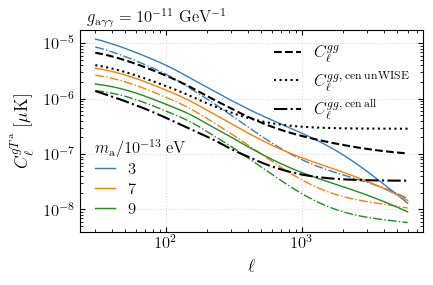

In [15]:
fig, ax = plt.subplots(1, 1, figsize=(4.5, 3.1))
cych = cycle(allcolors)


baseline = ghztoev(145)
units = xov(baseline) * baseline

mm, mmm = 30, 6000
elss = np.arange(mm,mmm)

unwise_color='blue'


for mind, MA in enumerate(dictKey):
    if mind not in [10, 30, 36]: continue
    col = next(cych)
    print(MA)
    epsilon = 1e-20

    Cell_taug = np.load(cl_data_galtau_path(MA, nZs, zMin, zreio, ellMax, name, unwise_color, choose_dict))
    Cell_taug*= epsilon**2. * TCMB * units
    ax.plot(elss, Cell_taug[mm:mmm], color=col, lw=1, label=r'${:.0f}$'.format(MA/1e-13))

    Cell_taug_cen = np.load(cl_data_galtau_path(MA, nZs, zMin, zreio, ellMax, name, unwise_color, choose_dict)+'centrals_only_unWISE.npy')
    Cell_taug_cen*= epsilon**2. * TCMB * units
    ax.plot(elss, Cell_taug_cen[mm:mmm], color=col, lw=1, ls='-.')

Cell_galgal0 = np.load(cl_data_galgal_path(nZs, zMin, zreio, ellMax, name, unwise_color, choose_dict))
l1, = ax.plot(np.arange(mm,mmm), Cell_galgal0[mm:mmm], color='k', ls='--')

Cell_galgal1 = np.load(cl_data_galgal_path(nZs, zMin, zreio, ellMax, name, unwise_color, choose_dict)+'centrals_only_unWISE.npy')
l2, = ax.plot(np.arange(mm,mmm), Cell_galgal1[mm:mmm], color='k', ls=':')

Cell_galgal2 = np.load(cl_data_galgal_path(nZs, zMin, zreio, ellMax, name, unwise_color, choose_dict)+'centrals_only.npy')
l3, = ax.plot(np.arange(mm,mmm), Cell_galgal2[mm:mmm], color='k', ls='-.')

secondary_labels = [r'$C_{\ell}^{gg}$', r'$C_{\ell}^{gg, {\rm \; cen \, unWISE}}$', r'$C_{\ell}^{gg, {\rm \; cen \, all}}$']
secondary_lines  = [l1, l2, l3]
ax.add_artist(plt.legend(secondary_lines, secondary_labels, loc=1, framealpha=1, handlelength=1.6, frameon=False))

ax.text(0.02, 1.1, r'$g_{{\rm a}\gamma\gamma} = 10^{-11} {\rm \; GeV^{-1}}$', transform=ax.transAxes, verticalalignment='top')
beautify(ax, times=-90, ncol=1, ttl=r'$m_{\rm a} / 10^{-13} {\rm \; eV}$', loc=3)#bb=(1.,1.))
ax.set_xscale('log')
ax.set_yscale('log')
ymin, ymax = ax.get_ylim()
#ax.set_ylim((5e-8, ymax))
#ax.xaxis.set_label_coords(0.5, -70*0.0015)
ax.set_ylabel(r'$C_\ell^{g T^{\rm a}} {\rm \; [\mu K]}$',fontsize=13)
ax.set_xlabel(r'$\ell$',fontsize=13)
plt.tight_layout()
plt.show()


In [19]:
bluetest = np.load('/home/dpirvu/axion/data_axion_Tg_battagliaAGN_blue_HOD21.npy')
greentest = np.load('/home/dpirvu/axion/data_axion_Tg_battagliaAGN_green_HOD21.npy')


3e-13
7e-13
9e-13


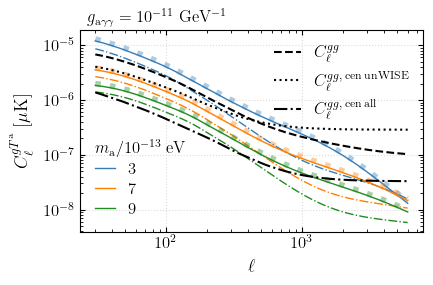

In [21]:
fig, ax = plt.subplots(1, 1, figsize=(4.5, 3.1))
cych = cycle(allcolors)


baseline = ghztoev(145)
units = xov(baseline) * baseline

mm, mmm = 30, 6000
elss = np.arange(mm,mmm)
unwise_color='blue'

for mind, MA in enumerate(dictKey):
    if mind not in [10, 30, 36]: continue
    col = next(cych)
    print(MA)
    epsilon = 1e-20

    ax.plot(elss, bluetest[mind, mm:mmm] * epsilon**2., color=col, ls=':', lw=4, alpha=0.4)

    Cell_taug = np.load(cl_data_galtau_path(MA, nZs, zMin, zreio, ellMax, name, unwise_color, choose_dict))
    Cell_taug*= epsilon**2. * TCMB * units
    ax.plot(elss, Cell_taug[mm:mmm], color=col, lw=1, label=r'${:.0f}$'.format(MA/1e-13))
    
    Cell_taug_cen = np.load(cl_data_galtau_path(MA, nZs, zMin, zreio, ellMax, name, unwise_color, choose_dict)+'centrals_only_unWISE.npy')
    Cell_taug_cen*= epsilon**2. * TCMB * units
    ax.plot(elss, Cell_taug_cen[mm:mmm], color=col, lw=1, ls='-.')

Cell_galgal0 = np.load(cl_data_galgal_path(nZs, zMin, zreio, ellMax, name, unwise_color, choose_dict))
l1, = ax.plot(np.arange(mm,mmm), Cell_galgal0[mm:mmm], color='k', ls='--')

Cell_galgal1 = np.load(cl_data_galgal_path(nZs, zMin, zreio, ellMax, name, unwise_color, choose_dict)+'centrals_only_unWISE.npy')
l2, = ax.plot(np.arange(mm,mmm), Cell_galgal1[mm:mmm], color='k', ls=':')

Cell_galgal2 = np.load(cl_data_galgal_path(nZs, zMin, zreio, ellMax, name, unwise_color, choose_dict)+'centrals_only.npy')
l3, = ax.plot(np.arange(mm,mmm), Cell_galgal2[mm:mmm], color='k', ls='-.')

secondary_labels = [r'$C_{\ell}^{gg}$', r'$C_{\ell}^{gg, {\rm \; cen \, unWISE}}$', r'$C_{\ell}^{gg, {\rm \; cen \, all}}$']
secondary_lines  = [l1, l2, l3]
ax.add_artist(plt.legend(secondary_lines, secondary_labels, loc=1, framealpha=1, handlelength=1.6, frameon=False))

ax.text(0.02, 1.1, r'$g_{{\rm a}\gamma\gamma} = 10^{-11} {\rm \; GeV^{-1}}$', transform=ax.transAxes, verticalalignment='top')
beautify(ax, times=-90, ncol=1, ttl=r'$m_{\rm a} / 10^{-13} {\rm \; eV}$', loc=3)#bb=(1.,1.))
ax.set_xscale('log')
ax.set_yscale('log')
ymin, ymax = ax.get_ylim()
#ax.set_ylim((5e-8, ymax))
#ax.xaxis.set_label_coords(0.5, -70*0.0015)
ax.set_ylabel(r'$C_\ell^{g T^{\rm a}} {\rm \; [\mu K]}$',fontsize=13)
ax.set_xlabel(r'$\ell$',fontsize=13)
plt.tight_layout()
plt.show()


In [ ]:
get_constraints = True

In [ ]:
if get_constraints:
    for eind, (expname, experiment) in enumerate(zip(['Planck', 'CMBS4'], [Planck, CMBS4])):
        # magnetic domains, #masses sampled, #forecast methods
        dictmasses = dictKey[:50]
        sigmaEpsilonList = np.ones((len(dictmasses), 2))/1e11

        if expname=='Planck':
            mm, mmm = 4, 3000
        if expname=='CMBS4':
            mm, mmm = 4, 6000

        ellss = np.arange(mm,mmm)

        model = modelParams
        fsky = 0.4
        for mind, MA in enumerate(dictmasses):
            zMin, zMax, rMin, rMax = chooseModel(MA, model)
            zMax = min(zreio, zMax)


            screening = np.zeros((3, ellMax))

            leftover = np.load(ILCnoisePS_path(MA, nZs, zMin, zreio, ellMax0, expname))

            Cell_gg_tot = np.load(cl_data_galgal_path(nZs, zMin, zreio, ellMax, name, unwise_color, choose_dict))

            Cell_taug_tot = np.load(cl_data_galtau_path(MA, nZs, zMin, zreio, ellMax, name, unwise_color, choose_dict))
            Cell_taug_tot = Cell_taug_tot * TCMB * units

            Cell_gg_cen = np.load(cl_data_galgal_path(nZs, zMin, zreio, ellMax, name, unwise_color, choose_dict)+'centrals_only_unWISE.npy')

            Cell_taug_cen = np.load(cl_data_galtau_path(MA, nZs, zMin, zreio, ellMax, name, unwise_color, choose_dict)+'centrals_only_unWISE.npy')
            Cell_taug_cen = Cell_taug_cen * TCMB * units


            # first constraint: CMB crossed with unWISE
            sigmaEpsilonList[mind, 0] = sigma_screeningVunWISE(0., fsky, mm, mmm, screening, leftover, Cell_taug_tot, Cell_gg_tot)

            # first constraint: CMB crossed with unWISE -- centrals only
            sigmaEpsilonList[mind, 1] = sigma_screeningVunWISE(0., fsky, mm, mmm, screening, leftover, Cell_taug_cen, Cell_gg_cen)

        np.save('/home/dpirvu/axion/data/constraints_data'+expname+'test.npy', sigmaEpsilonList*1e9)

    print('Done')

In [ ]:
for eind, (expname, experiment) in enumerate(zip(['Planck', 'CMBS4'], [Planck, CMBS4])):
    sigmaEpsilonList = np.load('/home/dpirvu/axion/data/constraints_data'+expname+'test.npy')
    expname0 = [r'$\rm \mathbf{Planck}$', r'$\rm \mathbf{CMB{-}S4}$'][eind]

    fig, ax = plt.subplots(1,1, figsize = (5.4,4.5))
    add_existing_constraints(ax, ylims=(2e-14, 3e-10), xlims=(1e-14, 1e-10))
    cych = cycle(allcolors[::])
    #magnetic domains, #masses sampled, #forecast methods
    secondary_lines, secondary_labels = [], []
    for method in range(len(sigmaEpsilonList.T)):
        col = next(cych)

        ycurve = sigmaEpsilonList[:, method]
        l1, = plt.plot(dictmasses, ycurve, color=col)
        secondary_lines.append(l1)
        secondary_labels.append(constraint2[method])

    ax.add_artist(plt.legend(secondary_lines, secondary_labels, title=expname0, framealpha=1, \
                             handlelength=1.4, bbox_to_anchor=(1.,.55), frameon=False))
    beautify(ax, times=-80)
    ax.xaxis.set_label_coords(0.5, -65*0.0015)
    plt.tight_layout()
    plt.show()

In [ ]:
constraint = [r'${\rm T}^{\rm a} \times {\, \rm g}$', \
              r'${\rm T}^{\rm a} \times {\, \rm g}^{\rm cen}$']
constraint2= [r'$\left\langle T^{\rm a} g \right\rangle $', \
              r'$\left\langle T^{\rm a} g^{\rm cen} \right\rangle $']

def add_existing_constraints(ax, ylims=(1e-14, 1e-9), xlims=(1e-15, 1e-9)):
    path_constr = './data/current_constraints/'
    cych = cycle(allcolors)

    labelscontours = np.array([r'${\rm SN}1987{\rm A-}\gamma$', \
                           r'$\rm Star \; Clusters$', \
                           r'${\rm NGC \;} 1275$'])

    data = np.genfromtxt(path_constr+'CAST_lim.txt')
    masses, data = data.T[0,:], data.T[1,:]
    plt.fill_between(masses, data, np.ones(len(masses)), color='gray', alpha=0.7)

    if True:
        coord, limit = np.load('./data/gas_contour.npy')
        col = 'royalblue'
        plt.fill_between(coord, limit/1e-9, np.ones(len(coord)), color=col, edgecolor=col)

        data = np.genfromtxt(path_constr+'SN1987A_gamma.txt')
        masses, data = data.T[0,:], data.T[1,:]
        l11, = plt.plot(masses, data, color='k', alpha=0.7)

        data = np.genfromtxt(path_constr+'Xray-SuperStarClusters_lim.txt')
        masses, data = data.T[0,:], data.T[1,:]
        l21, = plt.plot(masses[:-33], data[:-33], color='gray', alpha=0.7)

        data = np.genfromtxt(path_constr+'Chandra_NGC1275.txt')
        masses, data = data.T[0,:], data.T[1,:]
        l31, = plt.plot(masses[:-2], data[:-2], color='gray', alpha=0.3)

        secondary_lines = np.array([l11, l21, l31])
        secondary_labels = labelscontours

    ax.add_artist(plt.legend(secondary_lines, secondary_labels, ncol=3, columnspacing=1., framealpha=1, handlelength=1.3, loc=3, frameon=False))

    plt.text(2e-13,   3.9e-9,  r'$\rm FIRAS$', color='white', weight='bold')
    plt.text(1.5e-14, 7.3e-11, r'$\rm CAST$',  color='white', weight='bold', fontsize=13)
    plt.xlim(xlims)
    plt.ylim(ylims)
    plt.ylabel(r'$g_{{\rm a}\gamma\gamma} \; [{\rm GeV^{-1}}]$', fontsize=13)
    plt.xlabel(r'$m_{\rm a} \; [{\rm eV}]$', fontsize=13)
    plt.xscale('log')
    plt.yscale('log')
    plt.tight_layout()
    return ax
